<a href="https://colab.research.google.com/github/wadra/LLM_from_Scratch/blob/main/code/myedits/IMDB-GPU-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB GPU Demo

In this notebook (based on Shaan Khosla's [here](https://github.com/shaankhosla/catalyst/blob/main/main.ipynb)), we use the Hugging Face `transformers` library to illustrate how we can fine-tune an LLM to a specific task (in this case, predicting the sentiment of a film review using a classic [IMDB](https://www.imdb.com/) dataset).

We use a GPU and demonstrate how performance and GPU memory are impacted by LLM-training best-practices.

**Be sure to set *runtime type* to `GPU`.**

### Load dependencies

In [3]:
%%capture
!pip install transformers==4.25.1 datasets==2.4.0 nvidia-ml-py3==7.352.0 lime torchvision

In [4]:
# PyTorch:
import torch
import torch.nn.functional as F

# Hugging Face:
from datasets import load_dataset
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
)

# NVIDIA Management Library (for tracking GPU usage):
from pynvml import (
    nvmlInit,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlDeviceGetCount,
    nvmlDeviceGetName,
)

# Explainability:
from lime.lime_text import LimeTextExplainer
import random

### Utilities for GPU benchmarking

In [5]:
def print_gpu_utilization():
    nvmlInit()
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        info = nvmlDeviceGetMemoryInfo(handle)
        print("Device", i, ":", nvmlDeviceGetName(handle))
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    torch.cuda.empty_cache()

def print_summary(result):
    print(f"Training Loss: {result.training_loss:.4f}")
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

### Set device

In [6]:
torch.cuda.is_available()

True

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

Using device cuda


In [8]:
print_gpu_utilization()

Device 0 : b'Tesla T4'
GPU memory occupied: 260 MB.


In [9]:
torch.ones((1, 1)).to(DEVICE) # send a tensor to the GPU
print_gpu_utilization()

Device 0 : b'Tesla T4'
GPU memory occupied: 362 MB.


### Load model

The ["Dialog Ranking Pretrained Transformers up/down" model](huggingface.co/microsoft/DialogRPT-updown) is in the GPT-2 style and was trained for a task related to review-sentiment classification: predicting upvotes on a comment made online.

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained(
    "microsoft/DialogRPT-updown",
    model_max_length=1024,
    cache_dir="./cache/"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/812 [00:00<?, ?B/s]

In [11]:
model = GPT2ForSequenceClassification.from_pretrained(
    "microsoft/DialogRPT-updown",
    num_labels=2, # binary outcome: positive or negative review
    ignore_mismatched_sizes=True, # allows us to have two output neurons on model pre-trained with one
    cache_dir="./cache/",
).to(DEVICE)
model.config.use_cache = False

pytorch_model.bin:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialogRPT-updown and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([1, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
print_gpu_utilization()

Device 0 : b'Tesla T4'
GPU memory occupied: 1740 MB.


### Load and preprocess data

For real-time demonstration purposes, we'll use a very small dataset of only 25 training points (and 25 test points).

In [13]:
split = ["train[:25]", "test[:25]"]
raw_train, raw_test = load_dataset(
    "imdb",
    split=split,
    cache_dir="./cache/",
)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to ./cache/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
len(raw_train)

25

In [15]:
raw_train[2]["text"]

"If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />"

In [16]:
raw_train[2]["label"]

0

Note that the model won't actually be able to train, but that doesn't matter for the purposes of this demo:

In [17]:
for i in range(25):
  print(raw_train[i]["label"])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [18]:
tokenizer.encode(raw_train[2]["text"])

[1532,
 691,
 284,
 3368,
 1642,
 428,
 2099,
 286,
 2646,
 287,
 262,
 2003,
 13,
 770,
 2646,
 318,
 3499,
 355,
 281,
 6306,
 475,
 4952,
 645,
 43072,
 298,
 1621,
 29847,
 1671,
 1220,
 6927,
 1671,
 11037,
 3198,
 1244,
 1254,
 41276,
 329,
 5586,
 33834,
 340,
 780,
 340,
 18105,
 319,
 523,
 867,
 30023,
 9863,
 8643,
 2428,
 475,
 340,
 857,
 523,
 1231,
 597,
 22024,
 540,
 20289,
 13,
 383,
 19091,
 2058,
 1497,
 351,
 645,
 649,
 22582,
 357,
 25252,
 530,
 2058,
 510,
 351,
 530,
 981,
 530,
 338,
 2000,
 11569,
 364,
 11,
 355,
 340,
 481,
 31338,
 466,
 1141,
 428,
 27158,
 2646,
 737,
 27,
 1671,
 1220,
 6927,
 1671,
 11037,
 3198,
 1244,
 1365,
 4341,
 530,
 338,
 640,
 16143,
 503,
 257,
 4324,
 379,
 257,
 5509,
 3957,
 29847,
 1671,
 1220,
 6927,
 1671,
 11037]

In [19]:
train = raw_train.map(
    lambda x: {"input_ids": tokenizer(x["text"], truncation=True, padding="max_length")["input_ids"]},
    batched=True,
    remove_columns=['text'],
)
test = raw_test.map(
    lambda x: {"input_ids": tokenizer(x["text"], truncation=True, padding="max_length")["input_ids"]},
    batched=True,
    remove_columns=['text'],
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
train.column_names

['label', 'input_ids']

## Fine-tune model

### Vanilla training

In [21]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "no", # don't bother evaluating; if you want to after each epoch, set to "epoch" (other option is after set number of steps)
    "num_train_epochs": 1,
    "per_device_train_batch_size": 1,
}

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
print_summary(result)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 25
  Number of trainable parameters = 354825216


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Training Loss: 0.1294
Time: 22.25
Samples/second: 1.12
Device 0 : b'Tesla T4'
GPU memory occupied: 11124 MB.


### Gradient accumulation

In [22]:
default_args["gradient_accumulation_steps"] = 4

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
print_summary(result)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 354825216


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Training Loss: 0.0053
Time: 17.94
Samples/second: 1.39
Device 0 : b'Tesla T4'
GPU memory occupied: 12266 MB.


### Gradient checkpointing

In [23]:
default_args["gradient_checkpointing"] = True

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
print_summary(result)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 354825216
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Training Loss: 0.0001
Time: 25.19
Samples/second: 0.99
Device 0 : b'Tesla T4'
GPU memory occupied: 6542 MB.


### Mixed-precision training

Allow **mixed-precision** training of lower-precision data types (e.g., `fp16`, the "half-precision floating-point") with higher-precision data types (e.g., `fp32`, the "single-precision floating-point") during training:

In [24]:
default_args["fp16"] = True

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()
print_summary(result)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 354825216


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Training Loss: 0.0000
Time: 13.90
Samples/second: 1.80
Device 0 : b'Tesla T4'
GPU memory occupied: 6976 MB.


### Dynamic padding and uniform-length batching

In [25]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

train = raw_train.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)
test = raw_test.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)

trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=collate_fn,
)
result = trainer.train()
print_summary(result)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 354825216


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Training Loss: 0.0000
Time: 5.56
Samples/second: 4.50
Device 0 : b'Tesla T4'
GPU memory occupied: 6804 MB.


### Model Explainability with LIME

In [26]:
torch.cuda.empty_cache()

In [27]:
def predictor(texts):
    for t in random.sample(texts, 5):
        print(t, "\n")
    tokenized_text = tokenizer(
        texts, return_tensors="pt", padding=True, truncation=True
    )
    tokenized_text.to(DEVICE)
    outputs = model(**tokenized_text)
    tensor_logits = outputs[0].cpu()
    probas = F.softmax(tensor_logits).detach().numpy()
    return probas


def lime_explain():
    text = """
    If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.
One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).
One might better spend one's time staring out a window at a tree growing.
    """

    explainer = LimeTextExplainer(class_names=["negative", "positive"])

    exp = explainer.explain_instance(text, predictor, num_features=20, num_samples=25)
    fig = exp.as_pyplot_figure()
    fig.set_size_inches(18.5, 10.5)
    exp.save_to_file("explainable.html")
    fig.show()
    fig.savefig("explainable.jpg")


    If only to      film   .  film    an   tells  cogent .
 might feel        touches  so many     does so without  discernable motive.         (   up    ' mind wanders,     do   pointless film).
 might   '  staring   window    .
     


               .            .
                       .         (       '  ,         ).
    '         .
     


    If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.
One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).
One might better spend one's time staring out a window at a tree growing.
     


        making       . This     an experiment     .
    for          IMPORTANT issues        .     with   perspectives (    with   '  ,     do 

<ipython-input-27-964922ddad84>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(tensor_logits).detach().numpy()


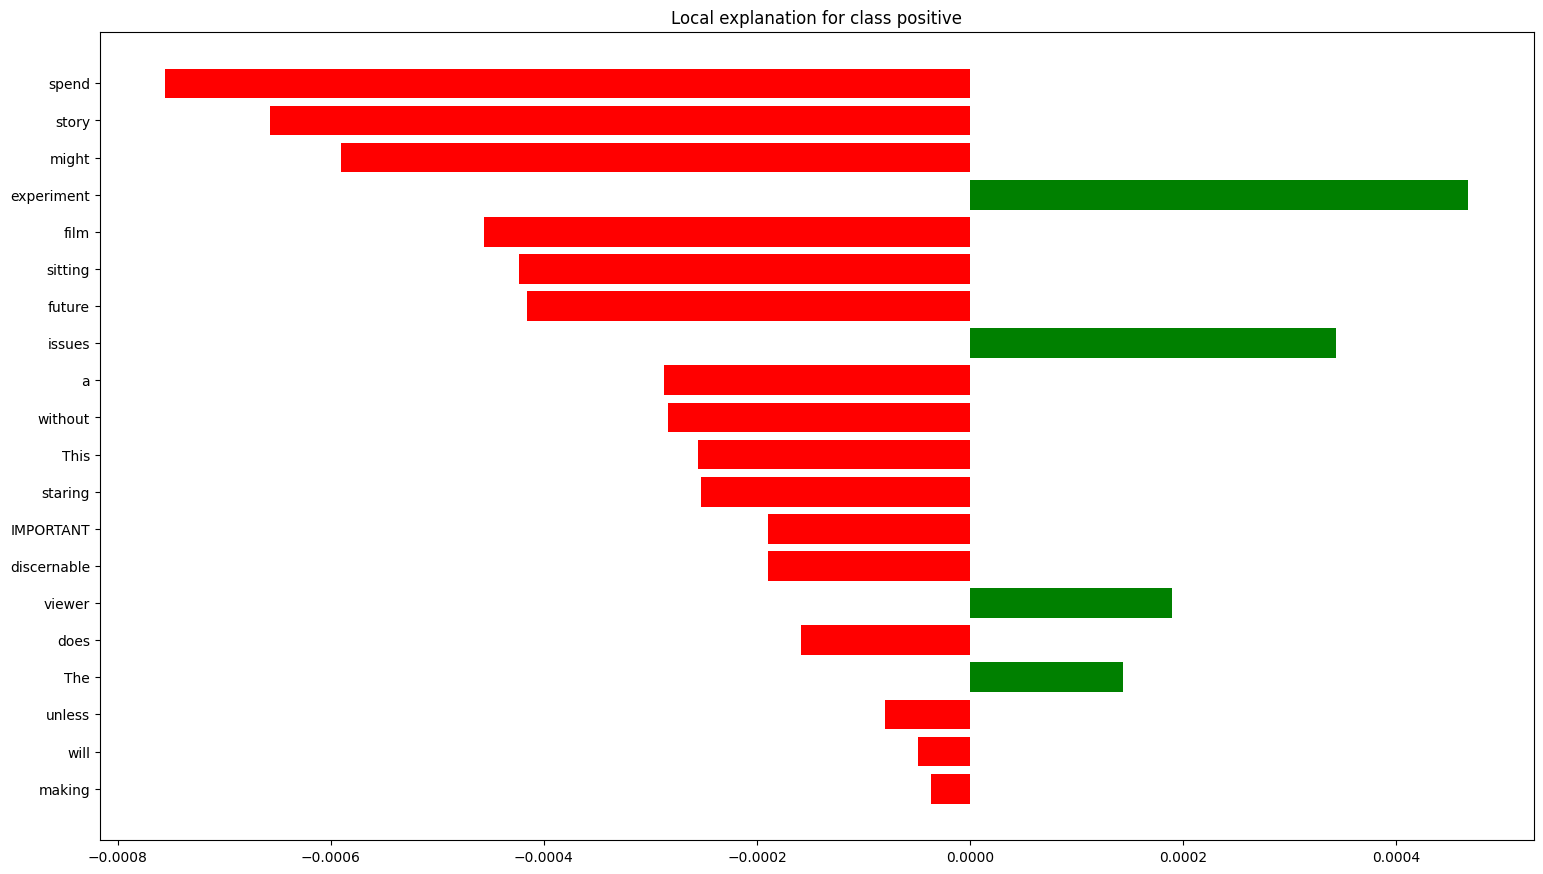

In [28]:
lime_explain()